# Prueba de evaluación 2

Realizado por Araceli Macía Barrado


## Parte 1


En esta primera parte trabajaremos con el API REST de 4chan:

https://github.com/4chan/4chan-API

(es conveniente tratar de comprender los campos que devuelve el JSON antes de comenzar,

siguiendo el ejemplo de clase)

Se pide lo siguiente:

• Obtener una muestra de dos boards de 4chan, sacando una instantánea concreta

(todas las páginas de cada board). Solo es necesario obtener la información requerida

para los puntos siguientes, no es necesario procesar todo.

• Contrastar diferencias en la media de respuestas por post en los dos boards elegidos.

• Obtener la distribución del tamaño de las imágenes en los posts de uno de los boards.




In [1]:
import requests as rq
r = rq.get('https://a.4cdn.org/boards.json')#no es la pagina web, es el datos que nos da el api.

import json
boards = json.loads(r.text) #pasamos el texto, y lo parsea.

import pandas as pd
import numpy as np

#transformo los datos a un dataframe

boardsframe = pd.DataFrame(columns=["title", "meta_description", "pages"])

def add_row(df, board):
    title = board["title"]
    metadesc = board["meta_description"]
    page = int(board["pages"])

    df.loc[board["board"]] = [title, metadesc,  page] 
    
for row in boards["boards"]:
    add_row(boardsframe, row)

    
print boardsframe["pages"].unique() #para ver los numeros distintos de paginas.
boardsframe.head(5)  


[ 10.   1.]


,title,meta_description,pages
3,3DCG,&quot;/3/ - 3DCG&quot; is 4chan's board for 3D...,10.0
a,Anime & Manga,&quot;/a/ - Anime &amp; Manga&quot; is 4chan's...,10.0
aco,Adult Cartoons,&quot;/aco/ - Adult Cartoons&quot; is 4chan's ...,10.0
adv,Advice,&quot;/adv/ - Advice&quot; is 4chan's board fo...,10.0
an,Animals & Nature,&quot;/an/ - Animals &amp; Nature&quot; is 4ch...,10.0


  >voy a seleccionar el de historia : **his** y el de fashion : **fa** . 
  Me parece muy curioso que todos los boards tengan 10 paginas..  los cortaran?

In [2]:
boar_fa= boardsframe.loc["fa"]
boar_his= boardsframe.loc["his"]




In [3]:
#genero una funcion para recorrer cada board, quedarme con los datos de replies (respuestas) y fsize tamaño

def recorrer_board(Datos,nombre):
  
    boardReturn = pd.DataFrame(columns=["idHilo","idPost","replies", "ext", "fsize"])
    size=Datos[2].astype(np.int32) 
    numpage=0
    
    for p in range(1, size):
        page = rq.get('https://a.4cdn.org/' + nombre + '/'+ str(p) +'.json')
        contents = json.loads(page.text)
        numhilo = 0
        numpage= numpage + 1
        for trh in contents["threads"]:  #cada pagina tiene threads 
            numhilo=numhilo+1
            numpost=0
            for post in trh["posts"]:  # cada thread tiene posts. El post de la posicion 0 es el que define el thread.
                numpost=numpost+1
                number = int(post["no"])
                replies = 0
                fsize = 0
                ext=""
                if ("replies" in post):
                    replies = int(post["replies"])
                if ("fsize" in post):
                    fsize = float(post["fsize"])
                    
                if ("ext" in post):
                    ext = post["ext"] 
                    
                boardReturn.loc[number] = [str(numpage)+str(numhilo), numpost,replies,ext, fsize]
    return  boardReturn  
    
dt_board_fa = recorrer_board(boar_fa,"fa")
print dt_board_fa.shape
dt_board_his= recorrer_board(boar_his,"his")
print dt_board_his.shape

(705, 5)
(704, 5)


In [4]:
print dt_board_fa["ext"].unique() #compruebo si todos los ficheros son imagenes
print dt_board_his["ext"].unique()

[u'.png' u'.jpg' '' u'.gif' u'.webm']
[u'.jpg' '' u'.png' u'.gif']


Hay ficheros de tipo .webm, que luego voy a quitar para analizar el tamaño de las imagenes.

### Contrastar diferencias en la media de respuestas por post en los dos boards elegidos.


In [5]:
media_fa=dt_board_fa["replies"].mean()
print "Media de respuestas del board Fashion", media_fa
media_his=dt_board_his["replies"].mean()
print "Media de respuestas del board de Historia", media_his



Media de respuestas del board Fashion 8.23546099291
Media de respuestas del board de Historia 6.53835227273


In [6]:
 #agrupo por el id de hilo ( formado por pagina e thread.), para obtener las respuestas de los post 
byHilo = dt_board_fa.groupby("idHilo")                                    
data_fa= byHilo["replies"].sum()
print data_fa[0:5]  #111    269.0  en la pagina 1, el thread 1, y el primer post tiene 269 respuestas.
byHilo = dt_board_his.groupby("idHilo") #agrupo por el id de hilo ( formado por pagina e thread.)
data_his= byHilo["replies"].sum()



idHilo
11       0.0
110    107.0
111     16.0
112     75.0
113      7.0
Name: replies, dtype: float64


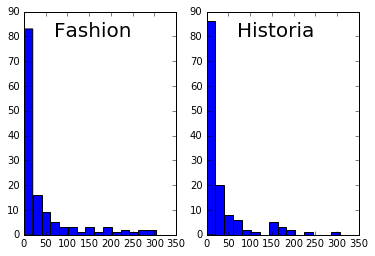

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.subplot(121)
plt.hist(data_fa, bins=15)
plt.text(70, 80, "Fashion",fontsize=20)

plt.subplot(122)
plt.hist(data_his,bins=15)
plt.text(70, 80, "Historia",fontsize=20)




En los graficos se puede ver que el numero de post sin respuesta es un poco mayor en Historia.
Y que existen mas post con alto numero de respuestas ( entre 100 y 300) en el post Fashion que en el de historia..  
Se confirma que la media de respuestas en los post de Fashion es superior.  Se ve que la gente tiene mas tema para hablar de cosas Fashion que de Historia..

###  Obtener la distribución del tamaño de las imágenes en los posts de uno de los boards.


In [8]:
tam_fa= dt_board_fa[dt_board_fa["fsize"]>0]  #me quedo con los datos donde el tamaño sea > 0
print tam_fa.head(2)   
tam_his= dt_board_his[dt_board_his["fsize"]>0]  #me quedo con los datos donde el tamaño sea > 0

#tengo que quitar los de tipo webm, que no son imagenes.
tam_fa= tam_fa[tam_fa["ext"]!=".webm"] #los webm son videos, los quito.
print tam_fa["ext"].unique()
print tam_his.head(2)    



         idHilo  idPost  replies   ext    fsize
6310205      11     1.0      0.0  .png  29410.0
11848443     12     1.0    282.0  .jpg  95379.0
[u'.png' u'.jpg' u'.gif']
        idHilo  idPost  replies   ext      fsize
27939       11     1.0      0.0  .jpg  2708828.0
1814554     12     1.0      3.0  .jpg    16565.0


<class 'matplotlib.axes._subplots.AxesSubplot'>


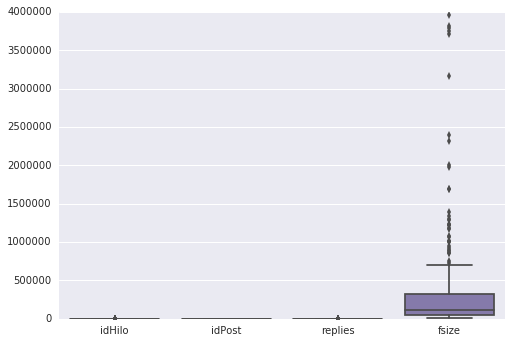

In [9]:
import seaborn as sns  #se importa como sns. 
ax = sns.boxplot(data=tam_fa) 
print type(ax) #pinto con esta libreria el dataframe entero.

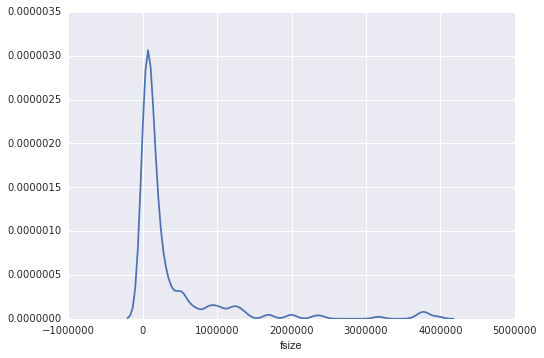

In [10]:
sns.distplot(tam_fa["fsize"], hist=False, rug=False) 

> tiene mucha cola de valores a la derecha..   no sigue una distribucion normal. Hay muchas fotos pequeñas.
como vemos en el bloxplot tiene muchos outliers, los voy a quitar.


In [11]:
#segun veo en la grafica de boxplot, hay valores por encima de 50000.. asi que los filtro.
print tam_fa[tam_fa["fsize"]>50000].shape #para ver el numero de valores que voy a quitar.
tam_fa= tam_fa[tam_fa["fsize"]<50000]  #me quedo con los datos que sean mas pequeños.

(182, 5)


<class 'matplotlib.axes._subplots.AxesSubplot'>


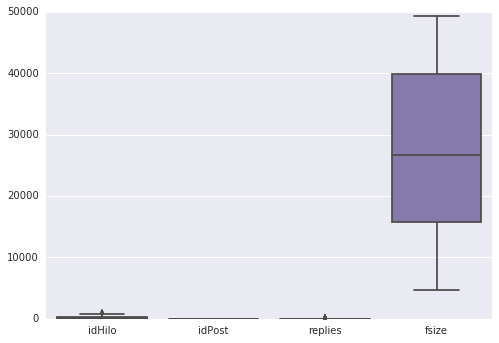

In [12]:
ax = sns.boxplot(data=tam_fa) 
print type(ax) #pinto con esta libreria el dataframe entero.


He eliminado los outliers, ahora parece que la media del tamaño esta en el centro, y que la varianza es igual en un sentido que en otro..  Segun el boxplot podria parecerse a una distribucion normal.

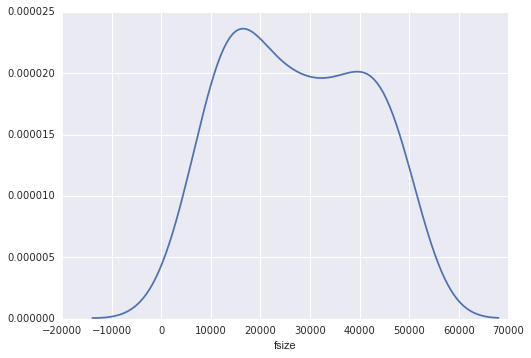

In [13]:
sns.distplot(tam_fa["fsize"], hist=False, rug=False) 

In [14]:
from scipy.stats.mstats import normaltest  #Estudiamos si la distribucion es normal o no.
_, pval1 = normaltest(tam_fa["fsize"])
print pval1

2.29632370798e-06


>> Con un valor negativo, se descarta la hipotesis de normalidad. La distribucion del tamaño de las imagenes que suben los usuarios al post Fashion no es normal.
